# 1D Heat Equation Eigenvalue Problem
\begin{align}
u_t &= u_{xx} \\
u(\pm 1) &= 0
\end{align}

In [1]:
import dedalus_sphere.jacobi as Jacobi

import numpy as np
import scipy as sp
import scipy.sparse as sparse
import matplotlib.pyplot as plt
%matplotlib notebook

np.set_printoptions(precision=3,suppress=True)

# Add '../' to path
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from eigtools import eigsort

# Jacobi operators
A = Jacobi.operator('A')
B = Jacobi.operator('B')
C = Jacobi.operator('C')
D = Jacobi.operator('D')
Id = Jacobi.operator('Id')


In [61]:
# 1D heat equation eigenvalues
# u_t = u_{zz}
Lmax, a, b = 256, 0, 0

In [62]:
evalues_analytic = ((np.arange(Lmax)+1)*np.pi/2)**2

In [66]:
# Base matrices
L = (D(+1) @ D(+1))(Lmax,a,b)
L = sparse.vstack([L, np.zeros((2,Lmax))])
M = ((A(+1) @ B(+1))**2)(Lmax,a,b)


# Tau method
bc = Jacobi.polynomials(Lmax,a,b,np.array([-1.0,1.0])).T
Lt, Mt = L.tocsr(), M
Mt[-2:,:] = 0
Lt[-2:,:] = bc

evalues_tau, evectors_tau = eigsort(Lt.todense(), -Mt.todense())


# Galerkin method
which = 'bottom'

bc = Jacobi.polynomials(Lmax,a,b,1)
if which == 'top':
    S = sparse.diags([np.concatenate(([1,1], bc[:-2])), -bc[2:]], [0, 2])
    Lg, Mg = L @ S, M @ S
    row = sparse.eye(2,Lmax)
    col = ((A(+1)@B(+1))**2)(Lmax,a,b)[:,-2:]
    zer = np.zeros((2,2))
    Lg = sparse.bmat([[Lg,  col],[  row,zer]])
    Mg = sparse.bmat([[Mg,0*col],[0*row,zer]])
    
elif which == 'bottom':
    S = sparse.diags([np.concatenate((bc[2:],[1,1])), -bc[:-2]], [0, -2])
    Lg, Mg = L @ S, M @ S
    Mg[-2:,:] = 0
    Lg[-2:,:] = 0
    Lg[-2,-2] = 1
    Lg[-1,-1] = 1
else:
    raise ValueError('bad which')

evalues_galerkin, evectors_galerkin = eigsort(Lg.todense(), -Mg.todense())


/opt/miniconda3/envs/dedalus/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/opt/miniconda3/envs/dedalus/lib/python3.7/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


<IPython.core.display.Javascript object>


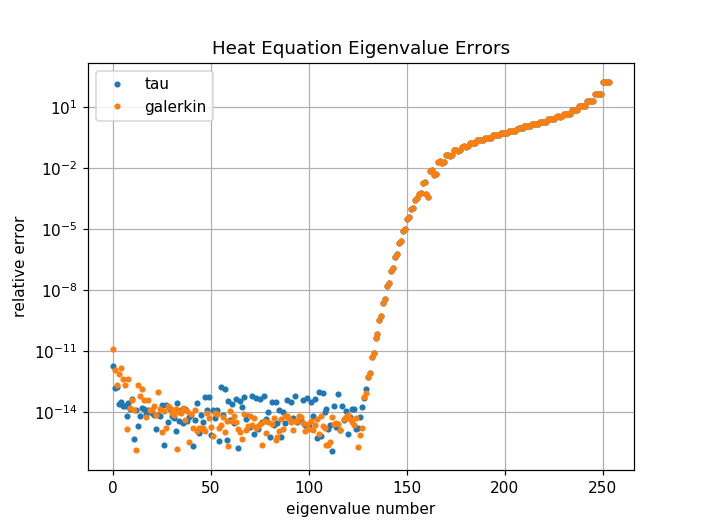

In [67]:
def error(vals):
    n = min(len(vals), len(evalues_analytic))
    return np.abs(vals[:n] - evalues_analytic[:n])/np.abs(evalues_analytic[:n])

errors_tau = error(evalues_tau)
errors_galerkin = error(evalues_galerkin)

plt.figure()
plt.semilogy(errors_tau, '.', label='tau')
plt.semilogy(errors_galerkin, '.', label='galerkin')
plt.legend()
plt.xlabel('eigenvalue number')
plt.ylabel('relative error')
plt.title('Heat Equation Eigenvalue Errors')
plt.grid()